In [178]:
!pip install -q vaderSentiment
!pip install -q transformers

### 1. Libraries

In [251]:
########################################
# Libraries
########################################

import os
import datetime
import numpy as np
import pandas as pd

# For Preprocessing
import re
import string
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

import pickle
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# For polarity scores labelling
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

from keras import losses
from keras import datasets
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## For data visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
sns.set_style('darkgrid')

## For BERT
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# Model evaluation
from sklearn import metrics
from keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

import warnings

# Temporarily suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 2. Dataset
1. `data1_month`: Posts containing the word 'AI' and its comments from January 2023 to May 2023.
2. `data2_subreddits`: Posts containing 'AI' from popular subreddits and its comments.
3. `data3_subreddits`: Posts containing 'Artificial Intelligence' from popular subreddits and its comments.


In [252]:
# Import datasets
df1 = pd.read_csv('./monthly_jan_may.csv')
df2 = pd.read_csv('./monthly_may_oct.csv')
df3 = pd.read_csv('./data2_subreddits.csv')
df4 = pd.read_csv('./data3_subreddits.csv')

In [253]:
# Dimensionality of the data
print("Dimensionality of datafram 1: ", df1.shape)
print("Dimensionality of datafram 2: ", df2.shape)
print("Dimensionality of datafram 3: ", df3.shape)
print("Dimensionality of datafram 3: ", df4.shape)

Dimensionality of datafram 1:  (14159, 5)
Dimensionality of datafram 2:  (1806, 5)
Dimensionality of datafram 3:  (25584, 5)
Dimensionality of datafram 3:  (11055, 5)


In [254]:
# Merge the dataframes together
df = pd.concat([df1, df2, df3, df4])
print("Dimensionality: ", df.shape)

Dimensionality:  (52604, 5)


In [255]:
# Only keep posts that contain `AI` keywords and remove duplicates
df = df[df['Post'].str.contains(r'\bAI\b|\bArtificial Intelligence\b|\bTechnology\b|\bTech\b', case=False, regex=True)]
df = df.drop_duplicates(subset='ID', keep='first')
print("Dimensionality: ", df.shape)
df.head()

Dimensionality:  (12353, 5)


,ID,Post,Author,Score,Created
0,12u4rzw,Messed around with my own Snapchat AI after se...,dross14,11620.0,1.682088e+09
1,12tucl5,"Snapchat AI “doesn’t know” my location, procee...",SpriteBleedin,6441.0,1.682063e+09
2,134jnsn,‘Godfather of AI’ quits Google with regrets an...,pstbo,45895.0,1.682940e+09
3,13457nm,When you spend 15 hours writing a 12 page case...,snowcamo53,44994.0,1.682894e+09
4,134g9zp,One of the creators of ChatGPT said that the d...,MINE_exchange,8313.0,1.682928e+09


In [256]:
# Only keep posts that have a lenght of at least 4 and not more than 40
df['Length'] = df['Post'].str.split().str.len()
df = df[(df['Length'] >= 4) & (df['Length'] <= 40)].reset_index(drop=True)
df.shape

(7735, 6)

In [257]:
print(df['Post'].iloc[6])
print(df['Post'].iloc[60])
print(df['Post'].iloc[600])
print(df['Post'].iloc[6000])

Man ends his life after an AI chatbot 'encouraged' him to sacrifice himself to stop climate change
This is surreal: ElevenLabs AI can now clone the voice of someone that speaks English (BBC's David Attenborough in this case) and let them say things in a language, they don't speak, like German.
How do you talk to the Ai?
How do you feel about the use of artificial intelligence in medicine, and do you believe it will lead to significant improvements in the quality of medical services and treatment?


### 3. VADER Sentiment Analysis
**Introduction**: Frequently, a well-labeled training dataset may not be available to you. In those circumstances, it is necessary to employ unsupervised techniques for sentiment prediction using tools such as `VADER`.

Punctuation, capitalization, preceding trigrams, conjunctions, and other elements have an impact on scores. `VADER` performs very well with emojis, slangs and acronyms in sentences as well. Therefore, to apply `VADER`, we must do a basic preprocessing and before we do modelling, we must continue with the preprocessing such as lowercasing, etc.



In [258]:
# Function to clean the text of the post
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

In [259]:
# Apply vader to get the polarity scores for each text
analyzer = SentimentIntensityAnalyzer()
df['Post'] = df['Post'].apply(lambda x:clean(x))

scores = []

for post in df['Post']:
    score = analyzer.polarity_scores(post)
    score = score['compound']
    scores.append(score)

In [260]:
# Transform the polarity scores into categories
sentiment = []

for score in scores:
    if score>=0.05:
        sentiment.append('Positive')
    elif score<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['Category'] = pd.Series(np.array(sentiment))

In [261]:
df.tail()

,ID,Post,Author,Score,Created,Length,Category
7730,c1jfe2d,AI is always defined as anything computers can...,fuckdapopo,1.0,1.299319e+09,10,Neutral
7731,d37myyf,I cant wait until AI agents start policing the...,SteelChicken,0.0,1.463416e+09,23,Negative
7732,c9kutdj,Right now it seems like AI is finally moving i...,uber_kerbonaut,1.0,1.366710e+09,22,Positive
7733,c0dwn89,But true AI WILL be possible in our life time!...,Corosus,2.0,1.254467e+09,37,Positive
7734,c1gkf31,"As a member of the dating community, and a fan...",danielamory,7.0,1.297562e+09,23,Positive


### 4. Find the Overall Sentiment

In [262]:
# Find the overral sentiment of the data using mean
scores = []

for sentence in df['Post']:
    score = analyzer.polarity_scores(sentence)
    scores.append(score)

df_scores = pd.DataFrame(scores)
print(df_scores.mean())

neg         0.080964
neu         0.797154
pos         0.121363
compound    0.089229
dtype: float64


### 5. Wordcloud Analysis of Posts

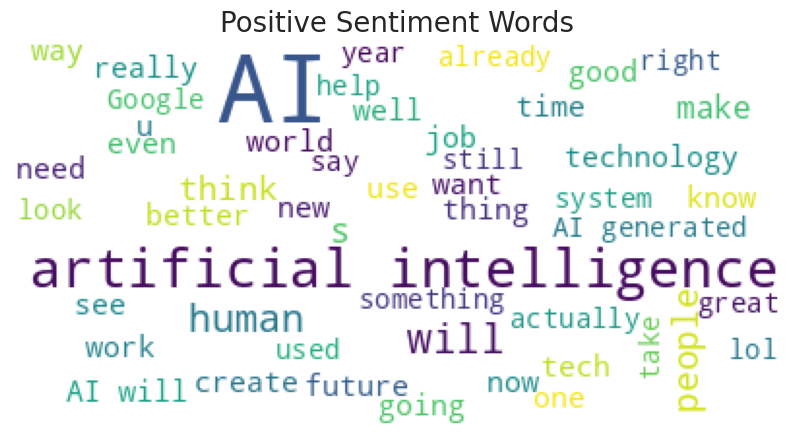

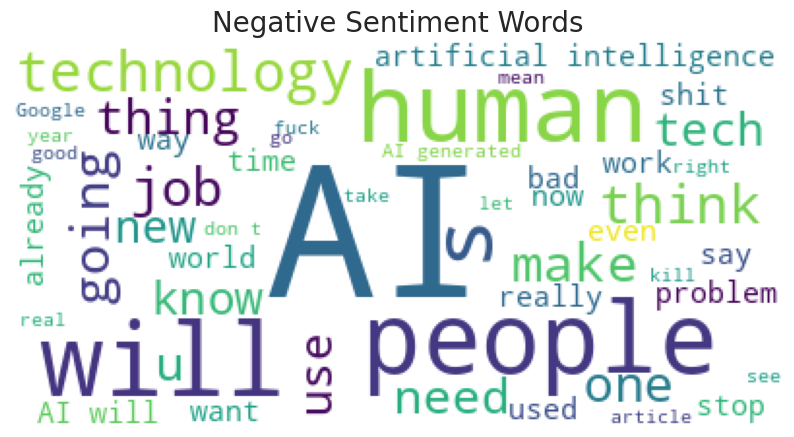

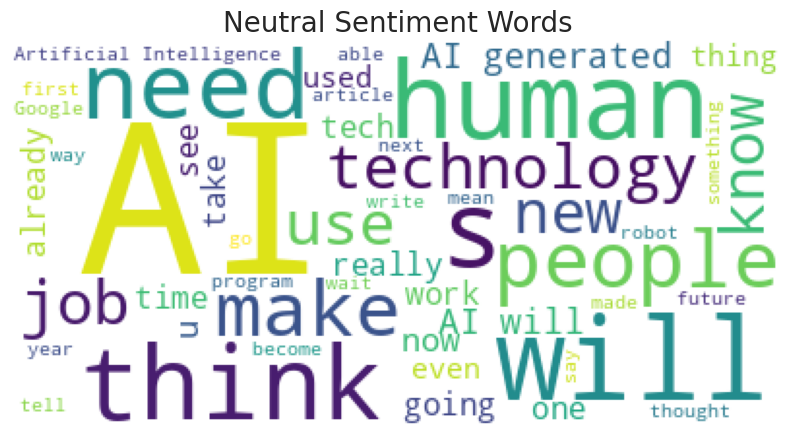

In [263]:
# Visualizing data into wordclouds
def wordcount_gen(df, sentiment):
    # Combine all posts
    combined_posts = " ".join([post for post in df[df.Category==sentiment]['Post']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_posts))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive post words
wordcount_gen(df, 'Positive')

# Negative post words
wordcount_gen(df, 'Negative')

# Neutral post words
wordcount_gen(df, 'Neutral')

### 6. Preprocessing: Tokenization, Stop-word and Punctuation Removal, Stemming and Lemmatization
**Stemming**: `Porter` and `Snowball`.

In [264]:
# Removing punctuations and making text lowercase
def clean_text(text):

    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df['Post'] = df['Post'].apply(lambda x:clean_text(x))

In [265]:
# Tokenize the posts
df_test = pd.DataFrame()
df_test['Post'] = df['Post']

def tokenization(text):
    text = re.split('\W+', text)
    return text

df_test['tokenized'] = df['Post'].apply(lambda x: tokenization(x.lower()))

In [266]:
negative_stopwords = ['no', 'nor','not',
 'only','don',
 "don't",'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

stopwords_original = nltk.corpus.stopwords.words('english')

stopword = [word for word in stopwords_original if word not in negative_stopwords]

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df_test['No_stopwords'] = df_test['tokenized'].apply(lambda x: remove_stopwords(x))

In [267]:
# Apply Porter Stemming
ps = nltk.PorterStemmer()

def porter_stemmer(text):
    text = [ps.stem(word) for word in text]
    return text

df_test['stemmed_porter'] = df_test['No_stopwords'].apply(lambda x: porter_stemmer(x))

In [268]:
# Apply Snowball Stemming
s_stemmer = SnowballStemmer(language='english')

def snowball_stemmer(text):
    text = [s_stemmer.stem(word) for word in text]
    return text
df_test['stemmed_snowball'] = df_test['No_stopwords'].apply(lambda x: snowball_stemmer(x))

In [269]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df_test['lemmatized'] = df_test['No_stopwords'].apply(lambda x: lemmatizer(x))

In [270]:
df_test.tail()

,Post,tokenized,No_stopwords,stemmed_porter,stemmed_snowball,lemmatized
7730,ai is always defined as anything computers can...,"[ai, is, always, defined, as, anything, comput...","[ai, always, defined, anything, computers, can...","[ai, alway, defin, anyth, comput, cannot, yet]","[ai, alway, defin, anyth, comput, cannot, yet]","[ai, always, defined, anything, computer, cann..."
7731,i cant wait until ai agents start policing the...,"[i, cant, wait, until, ai, agents, start, poli...","[cant, wait, ai, agents, start, policing, inte...","[cant, wait, ai, agent, start, polic, internet...","[cant, wait, ai, agent, start, polic, internet...","[cant, wait, ai, agent, start, policing, inter..."
7732,right now it seems like ai is finally moving i...,"[right, now, it, seems, like, ai, is, finally,...","[right, seems, like, ai, finally, moving, righ...","[right, seem, like, ai, final, move, right, di...","[right, seem, like, ai, final, move, right, di...","[right, seems, like, ai, finally, moving, righ..."
7733,but true ai will be possible in our life time ...,"[but, true, ai, will, be, possible, in, our, l...","[true, ai, possible, life, time, either, die, ...","[true, ai, possibl, life, time, either, die, t...","[true, ai, possibl, life, time, either, die, t...","[true, ai, possible, life, time, either, die, ..."
7734,as a member of the dating community and a fan ...,"[as, a, member, of, the, dating, community, an...","[member, dating, community, fan, artificial, i...","[member, date, commun, fan, artifici, intellig...","[member, date, communiti, fan, artifici, intel...","[member, dating, community, fan, artificial, i..."


As we can see, the stemming does not perform very well since some words were truncated incorrectly. Therefore, we should use Lemmatization instead

In [271]:
df['Post'] = df_test['lemmatized']
df['Post'] = [' '.join(map(str, l)) for l in df['Post']]

### 7. Sentiment Categories Visualization

<Axes: xlabel='Category', ylabel='count'>

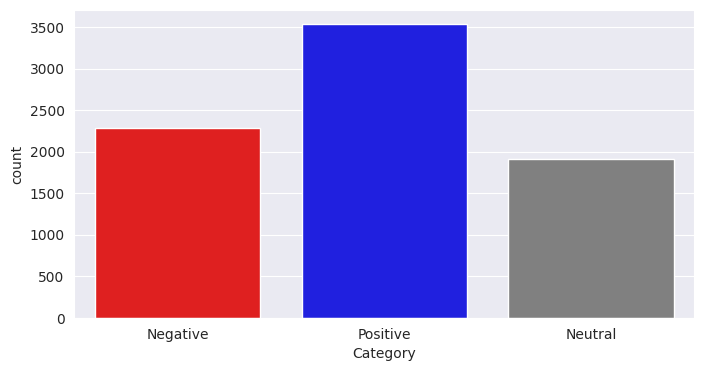

In [272]:
plt.figure(figsize=(8,4))
sns.countplot(x='Category',data=df, palette=['red',"blue", "grey"])

In [273]:
category_count_posts = df.groupby('Category').count()['Post'].reset_index().sort_values(by='Post',ascending=False)

fig = go.Figure(go.Funnelarea(
    text = category_count_posts.Category,
    values = category_count_posts.Post,
    title = {"position": "top center", "text": "Chart of Sentiment Distribution"}
    ))
fig.show()

#### 7.2 Time Based Analysis on Posts
We can see there is a steeper rise of positive posts in the past years compared to other categories.

In [274]:
# remove NaN values
df = df[df['Created'].notnull()]

# Modify date to graph
def format_date(date):
  return datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d %H:%M:%S')

df['Created'] = df['Created'].apply(format_date)

<Figure size 10000x1000 with 0 Axes>

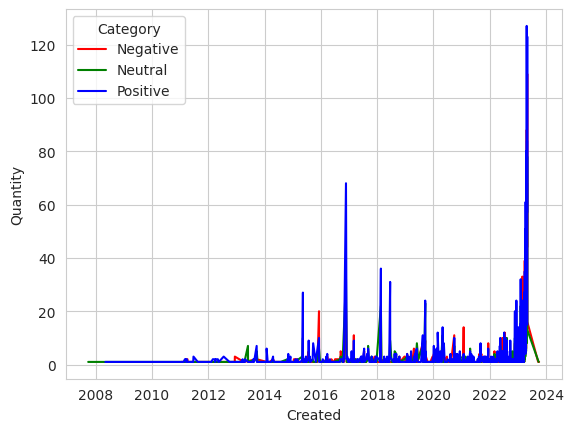

<Figure size 10000x1000 with 0 Axes>

In [275]:
df['Created'] = pd.to_datetime(df.Created)

timeline = df.resample('D', on='Created')["Category"].value_counts().unstack(1)
timeline.reset_index(inplace=True)

timeline = timeline.melt("Created", var_name='Category',  value_name='Quantity')

sns.set_style("whitegrid")
sns.lineplot(x="Created", y="Quantity", hue="Category", data=timeline, palette=["r", "g","b"])
plt.figure(figsize=(100,10))

#### 7.4 Post Length Distribution

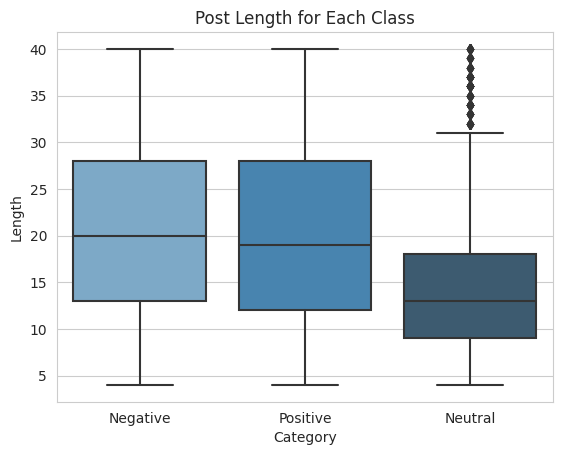

In [276]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x = df['Category'], y = df['Length'], data = df, palette=("Blues_d"))
plt.title('Post Length for Each Class')
plt.show()

### 8. Modelling

In [277]:
# Encode target labels
le = LabelEncoder()
X = df['Post']
Y = le.fit_transform(df['Category'])

#### 8.1 Bidirectional LSTM

##### 8.1.1 Bag of Words (BOW) Feature Extraction

In [278]:
y = pd.get_dummies(df['Category'])

# split between train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

vocabulary_size = 6000
count_vector = CountVectorizer(max_features=vocabulary_size,
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



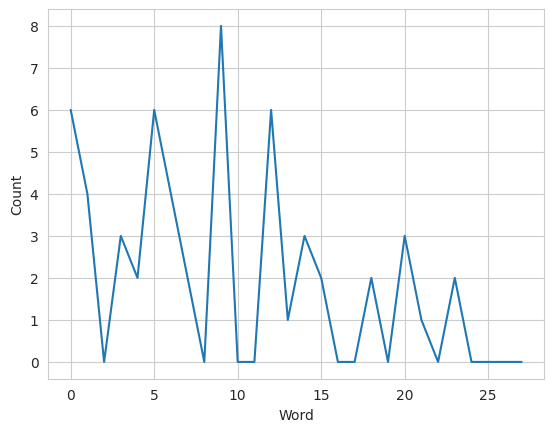

In [279]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [280]:
max_words = 6000
max_len = 40

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before \n', df['Post'][10])
X, tokenizer = tokenize_pad_sequences(df['Post'])
print('After \n', X[10])

Before 
 ceo openai say current approach ai soon reach limit scaling llm model stop delivering improvement ai new approach needed
After 
 [ 170  414   40  181  650    1  157  882  784 5210 1291  100   91 3631
 1001    1   25  650  415    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


##### 8.1.2 Train and Test Split

In [281]:
y = pd.get_dummies(df['Category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (4950, 40) (4950, 3)
Validation Set:  (1238, 40) (1238, 3)
Test Set:  (1547, 40) (1547, 3)


##### 8.1.3 Neural Network

In [330]:
vocab_size = 6000
embedding_size = 32
epochs = 20
learning_rate = 0.001

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Neural network architecture
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

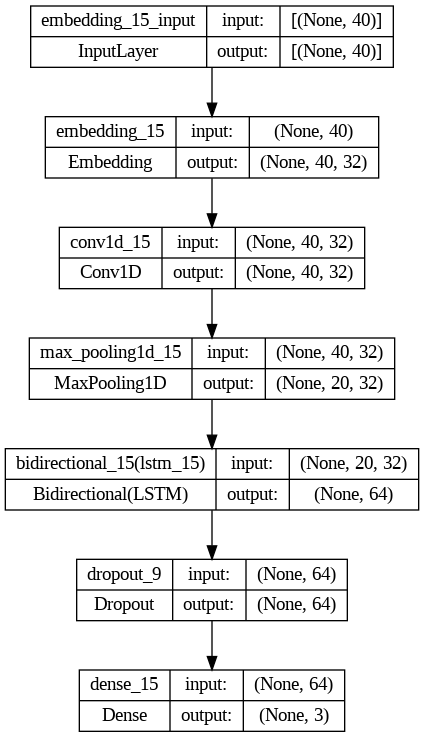

In [331]:
# Visualize the architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [335]:
# Compile model
model.compile(optimizer=optimizer,  # Adam optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
batch_size = 32
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stopping])

Epoch 1/20
155/155 [==============================] - 16s 80ms/step - loss: 0.4426 - accuracy: 0.8422 - precision_16: 0.8625 - recall_16: 0.8158 - val_loss: 0.7127 - val_accuracy: 0.7286 - val_precision_16: 0.7494 - val_recall_16: 0.7027
Epoch 2/20
155/155 [==============================] - 5s 33ms/step - loss: 0.2263 - accuracy: 0.9295 - precision_16: 0.9372 - recall_16: 0.9198 - val_loss: 0.9078 - val_accuracy: 0.6995 - val_precision_16: 0.7128 - val_recall_16: 0.6817
Epoch 3/20
155/155 [==============================] - 3s 19ms/step - loss: 0.1410 - accuracy: 0.9600 - precision_16: 0.9639 - recall_16: 0.9554 - val_loss: 1.0725 - val_accuracy: 0.6995 - val_precision_16: 0.7057 - val_recall_16: 0.6858
Epoch 4/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0895 - accuracy: 0.9756 - precision_16: 0.9773 - recall_16: 0.9723 - val_loss: 1.2052 - val_accuracy: 0.6890 - val_precision_16: 0.6942 - val_recall_16: 0.6785
Epoch 5/20
155/155 [==============================]

##### 8.1.4 Evaluation Metrics

In [336]:
# Function to calculate f1 score
def calc_f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [337]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.3f}'.format(accuracy))
print('Precision : {:.3f}'.format(precision))
print('Recall    : {:.3f}'.format(recall))
print('F1 Score  : {:.3f}'.format(calc_f1_score(precision, recall)))

Accuracy  : 0.709
Precision : 0.725
Recall    : 0.674
F1 Score  : 0.699


49/49 [==============================] - 1s 3ms/step


Text(45.722222222222214, 0.5, 'Predicted label')

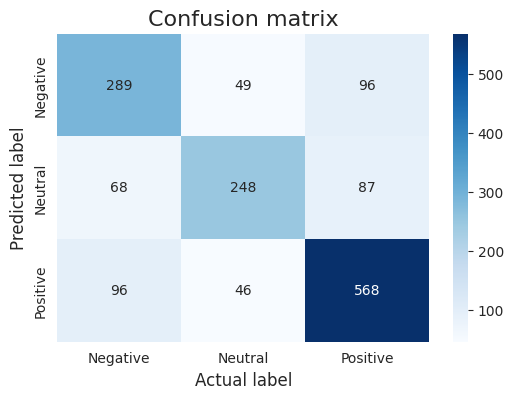

In [216]:
sentiment_classes = ['Negative', 'Neutral', 'Positive']

# predict
y_pred = model.predict(X_test)

# compute the confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

# plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)


#### 8.2 Conventional ML Models

In [217]:
# Get the target values
X = df['Post']
y = df['Category']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

##### 8.2.1 Random Forest

In [218]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5,
                                              n_estimators=100))])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00       579
     Neutral       0.00      0.00      0.00       480
    Positive       0.45      1.00      0.62       875

    accuracy                           0.45      1934
   macro avg       0.48      0.33      0.21      1934
weighted avg       0.50      0.45      0.28      1934



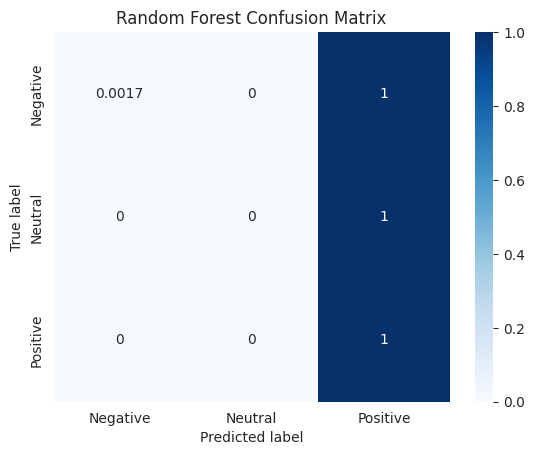

In [219]:
# Create a classification report for the RF model
print(metrics.classification_report(y_valid, y_pred_rf))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.2 Naive Bayes classification

In [220]:
# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)


              precision    recall  f1-score   support

    Negative       0.76      0.30      0.43       579
     Neutral       0.86      0.07      0.12       480
    Positive       0.51      0.97      0.66       875

    accuracy                           0.54      1934
   macro avg       0.71      0.44      0.41      1934
weighted avg       0.67      0.54      0.46      1934



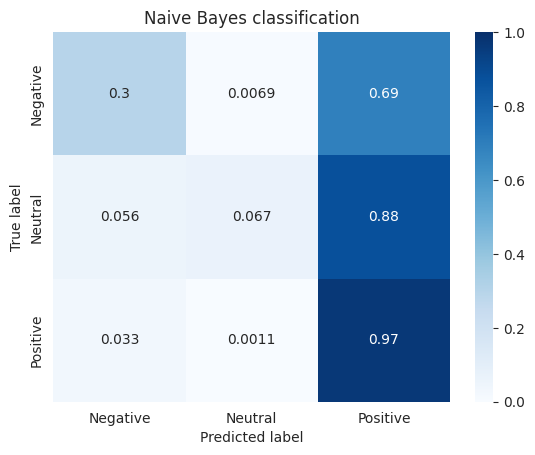

In [221]:
# Create a classification report for the Naive Bayes model
print(metrics.classification_report(y_valid, y_pred_nb))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Naive Bayes classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.3 K Nearest Neighbors classification¶

In [222]:
# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5,
                                             metric='minkowski',
                                             p=2))])

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.50      0.01      0.01       579
     Neutral       0.25      0.99      0.40       480
    Positive       0.74      0.03      0.06       875

    accuracy                           0.26      1934
   macro avg       0.50      0.34      0.16      1934
weighted avg       0.55      0.26      0.13      1934



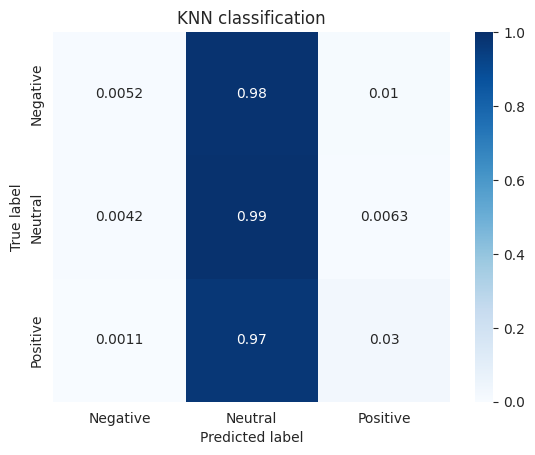

In [223]:
# Create a classification report for the KNN model
print(metrics.classification_report(y_valid, y_pred_knn))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_knn)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('KNN classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.4 Logistic regression

In [224]:
# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1,
                                         class_weight='balanced',
                                         max_iter=1000))])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.66      0.67      0.66       579
     Neutral       0.63      0.75      0.69       480
    Positive       0.81      0.72      0.77       875

    accuracy                           0.71      1934
   macro avg       0.70      0.71      0.71      1934
weighted avg       0.72      0.71      0.72      1934



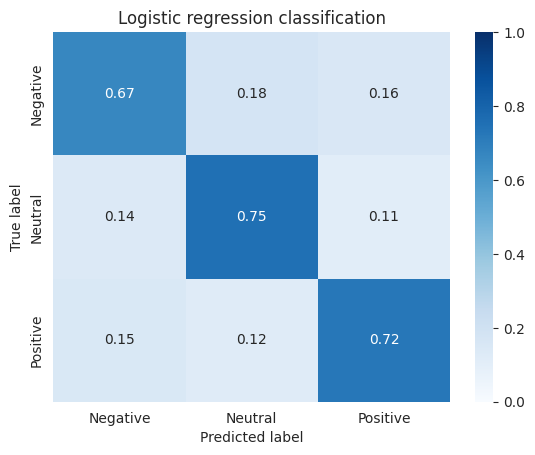

In [225]:
# Create a classification Report for the model
print(metrics.classification_report(y_valid, y_pred_lr))

cm = confusion_matrix(y_valid, y_pred_lr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Heatmap for the results
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Logistic regression classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.5 Linear SVC classification

In [226]:
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC())])

lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.70      0.65      0.68       579
     Neutral       0.69      0.65      0.67       480
    Positive       0.75      0.81      0.78       875

    accuracy                           0.73      1934
   macro avg       0.72      0.71      0.71      1934
weighted avg       0.72      0.73      0.72      1934



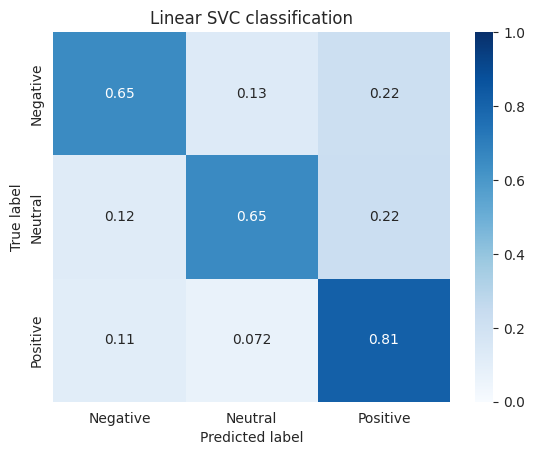

In [227]:
# Create the classification Report for the linear SVC model
print(metrics.classification_report(y_valid, y_pred_lsvc))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lsvc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Linear SVC classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### 8.3 LLM

In [228]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

##### 8.3.1 BERT

In [241]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 46
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [242]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.description = dataframe.Post
        self.targets = dataframe.Category
        self.max_len = max_len

    def __len__(self):
        return len(self.description)

    def __getitem__(self, index):
        description = str(self.description[index])
        description = " ".join(description.split())

        inputs = self.tokenizer.encode_plus(
            description,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        # Check if the sequence length exceeds max_len
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
            mask = mask[:self.max_len]
            token_type_ids = token_type_ids[:self.max_len]

        # Convert the target to an integer (assuming self.targets is a column of integers)
        target = int(self.targets[index])

        # Cast all tensors to torch.long before moving to the device
        ids = torch.tensor(ids, dtype=torch.long)
        mask = torch.tensor(mask, dtype=torch.long)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
        target = torch.tensor(target, dtype=torch.long)

        # Move all tensors to the device (CPU or GPU)
        ids = ids.to(device)
        mask = mask.to(device)
        token_type_ids = token_type_ids.to(device)
        target = target.to(device)

        return {
            'ids': ids,
            'mask': mask,
            'token_type_ids': token_type_ids,
            'targets': target
        }

In [243]:
# Creating the dataset and dataloader for the neural network

label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

train_size = 0.7
train_dataset = df.sample(frac=train_size,random_state=200)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [244]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [245]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

num_classes = 3
model = BERTClass(num_classes)
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [246]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [247]:
# loss function
def loss_fn(outputs, targets):
    # Cast targets to torch.int64
    targets = targets.to(torch.int64)
    return torch.nn.CrossEntropyLoss()(outputs, targets)

# training
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%100==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# validation
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [236]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  1.0911697149276733
Epoch: 0, Loss:  1.0216257572174072
Epoch: 0, Loss:  0.848751962184906
Epoch: 0, Loss:  0.8709415197372437
Epoch: 0, Loss:  0.320827454328537
Epoch: 0, Loss:  0.6436105370521545
Epoch: 0, Loss:  0.7463005781173706
Epoch: 1, Loss:  0.5575709342956543
Epoch: 1, Loss:  0.1998285949230194
Epoch: 1, Loss:  0.8813791275024414
Epoch: 1, Loss:  0.18474513292312622
Epoch: 1, Loss:  0.6140341758728027
Epoch: 1, Loss:  0.8375637531280518
Epoch: 1, Loss:  0.5298694372177124


In [237]:
all_outputs = []
all_targets = []

for epoch in range(EPOCHS):
    # Call the validation function
    fin_outputs, fin_targets = validation(epoch)
    # Extend the lists with batch-level results
    all_outputs.extend(fin_outputs)
    all_targets.extend(fin_targets)

all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)

all_targets = all_targets.astype(int)

# Compute argmax to get predicted labels for each sample
predicted_labels = all_outputs.argmax(axis=1)

# Calculate accuracy and F1
accuracy = accuracy_score(all_targets, predicted_labels)
f1_score_micro = f1_score(all_targets, predicted_labels, average='micro')
f1_score_macro = f1_score(all_targets, predicted_labels, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8061180525635502
F1 Score (Micro) = 0.8061180525635502
F1 Score (Macro) = 0.794868191968872


#### 9. Prediction

In [238]:
# Saving file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Open file to use
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [239]:
def predict_class(text):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len = 40

    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize and convert text to input features
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sentence in text:
        # Tokenize the text
        inputs = tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(inputs.input_ids)
        attention_masks.append(inputs.attention_mask)
        token_type_ids.append(inputs.token_type_ids)

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    token_type_ids = torch.cat(token_type_ids, dim=0).to(device)

    # Predict using the model
    logits = model(input_ids, mask=attention_masks, token_type_ids = token_type_ids)

    # Convert logits to predicted class
    yt = torch.argmax(logits, dim=1).cpu().numpy()

    for i, sentence in enumerate(text):
        print('Sentence:', sentence)
        print('Prediction:', sentiment_classes[yt[i]], '\n')

In [240]:
predict_class(["NSA announces new artificial intelligence security center: 'Desperately needed'"])
predict_class(["The Amazing Ways Chinese Tech Giant Alibaba Uses Generative Artificial Intelligence"])
predict_class(["AI Needs Data More Than Data Needs AI"])
predict_class(["Athens Democracy Forum: Are Artificial Intelligence and Democracy Compatible?"])
predict_class(["Chicago starts taxing ChatGPT, artificial intelligence"])
predict_class(["AI is replacing customer service jobs across the globe"])
predict_class(["AI tools make things up a lot, and that’s a huge problem"])
predict_class(["Educators embrace usefulness of artificial intelligence in classrooms, note potential problems"])
predict_class(["Tom Hanks has a warning about AI creating a 'fake' Tom Hanks"])

Sentence: NSA announces new artificial intelligence security center: 'Desperately needed'
Prediction: Positive 

Sentence: The Amazing Ways Chinese Tech Giant Alibaba Uses Generative Artificial Intelligence
Prediction: Positive 

Sentence: AI Needs Data More Than Data Needs AI
Prediction: Neutral 

Sentence: Athens Democracy Forum: Are Artificial Intelligence and Democracy Compatible?
Prediction: Positive 

Sentence: Chicago starts taxing ChatGPT, artificial intelligence
Prediction: Positive 

Sentence: AI is replacing customer service jobs across the globe
Prediction: Neutral 

Sentence: AI tools make things up a lot, and that’s a huge problem
Prediction: Negative 

Sentence: Educators embrace usefulness of artificial intelligence in classrooms, note potential problems
Prediction: Positive 

Sentence: Tom Hanks has a warning about AI creating a 'fake' Tom Hanks
Prediction: Negative 

